# "Human or Robot" 
## Predicting Auction Fraud

On an auction website, human bidders are becoming increasingly frustrated with their inability to win auctions vs. their software-controlled counterparts. As a result, usage from the site's core customer base is plummeting. In order to rebuild customer happiness, the site owners need to eliminate computer generated bidding from their auctions.

The goal of this project is to identify online auction bids that are placed by "robots", thus helping the site owners easily flag these users for removal from their site to prevent unfair auction activity.

<img src="../images/robots-greeting.png" width="500">

## PRE PROCESSING AND MODELING
- Models to train
    - Logistic Regression
    - k-Nearest Neighbors
    - Decision Trees
    - Support Vector Machine
    - Naive Bayes

- Evaluation
- Conclusion

In [33]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Modeling
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

from IPython.display import display
import matplotlib.ticker as ticker
import pylab as pl
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from scipy import interp
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
# from xgboost import XGBClassifier

from sklearn.model_selection import RepeatedStratifiedKFold


from matplotlib.pylab import rcParams
rcParams['figure.figsize']=25,25

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load df
df = pd.read_csv('../data/features-outcome-df')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1984 entries, 0 to 1983
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   outcome               1984 non-null   float64
 1   bids_per_auction      1984 non-null   int64  
 2   country_per_user      1984 non-null   int64  
 3   device_per_user       1984 non-null   int64  
 4   ip_bids_per_user      1984 non-null   float64
 5   url_bids_per_user     1984 non-null   float64
 6   bots_country          1984 non-null   float64
 7   bots_device           1984 non-null   float64
 8   bids_per_user         1984 non-null   int64  
 9   url_per_user          1984 non-null   int64  
 10  auction_per_user      1984 non-null   int64  
 11  ip_per_user           1984 non-null   int64  
 12  bids_per_device       1984 non-null   int64  
 13  bids_per_coutry       1984 non-null   int64  
 14  avg_bids_per_user     1984 non-null   float64
 15  median_bids_per_user 

In [3]:
df.columns

Index(['outcome', 'bids_per_auction', 'country_per_user', 'device_per_user',
       'ip_bids_per_user', 'url_bids_per_user', 'bots_country', 'bots_device',
       'bids_per_user', 'url_per_user', 'auction_per_user', 'ip_per_user',
       'bids_per_device', 'bids_per_coutry', 'avg_bids_per_user',
       'median_bids_per_user', 'auto parts', 'books and music', 'clothing',
       'computers', 'furniture', 'home goods', 'jewelry', 'mobile',
       'office equipment', 'sporting goods'],
      dtype='object')

### Response and Explanatory Variables

In [4]:
# declare response variable Y
y = df['outcome']

# keep explanatory variables X
X = df[['bids_per_auction', 'country_per_user', 'device_per_user',
       'ip_bids_per_user', 'url_bids_per_user', 'bots_country', 'bots_device',
       'bids_per_user', 'url_per_user', 'auction_per_user', 'ip_per_user',
       'bids_per_device', 'bids_per_coutry', 'avg_bids_per_user',
       'median_bids_per_user', 'auto parts', 'books and music', 'clothing',
       'computers', 'furniture', 'home goods', 'jewelry', 'mobile',
       'office equipment', 'sporting goods']]

- Response variable:

In [13]:
from collections import Counter

# summarize observations by class label
counter = Counter(y)
print(counter)

Counter({0.0: 1881, 1.0: 103})


We have an imbalanced classification problem which is common in fraud detections as this is. Specialized techniques may be used to change the composition of samples in the training dataset by undersampling the majority class or oversampling the minority class.

We can use:
- Random Undersampling.
- SMOTE Oversampling.

Specialized modeling algorithms may be used that pay more attention to the minority class when fitting the model on the training dataset, such as cost-sensitive machine learning algorithms.

Examples include:

- Cost-sensitive Logistic Regression.
- Cost-sensitive Decision Trees.
- Cost-sensitive Support Vector Machines.


### Test Train Split

In [34]:
# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.20, random_state = 42)

# Check the shape of the X train, y_train, X_test and y_test to make sure the proportions are right
print('X_train: ', X_train.shape, 'y_train: ', y_train.shape, 'X_test :' ,X_test.shape,
      'y_test: ', y_test.shape)

X_train:  (1587, 25) y_train:  (1587,) X_test : (397, 25) y_test:  (397,)


### Models Training

In [35]:
# instantiate model
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(n_estimators=600, max_depth=15, min_samples_leaf=2)
print(cross_val_score(rf, X_train, y_train, cv=3).mean())

0.9533711405166981


In [36]:
# Data preprocesses
def prep(raw_features, exclude=[]):
    
    prep_features = pd.DataFrame()
    #Listing the columns
    numerical = list(raw_features.columns)
    
    for e in exclude:
        try:
            numerical.remove(e)
        except:
            print('Removing name %s not in the feature set.'%e)
    
    #Data preprocessed by log transformation
    prep_features[numerical]=raw_features[numerical].apply(lambda x:np.log(x+1e-5))
    
    #Data preprocessed by MinMaxScaler
    scalar = MinMaxScaler()
    prep_features[numerical] = scalar.fit_transform(raw_features[numerical])
    
    return prep_features

In [37]:
prep_features_train = prep(X)

In [38]:
def model_compare(models, feature_set, label_set, model_names, colors, kfold = 10):
    from matplotlib.pylab import rcParams
    
    rcParams['figure.figsize'] = 15,15
    for model in models:
        model_name = model_names[models.index(model)]
        color = colors[models.index(model)]
        cv = StratifiedKFold(n_splits = kfold)
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)
        i=0
        
        for train, val in cv.split(feature_set,label_set):
            probas_= model.fit(feature_set.iloc[train], label_set.iloc[train].values.ravel()).predict_proba(feature_set.iloc[val])
            
            #compute ROC curve and AUC
            fpr,tpr,threshold = roc_curve(label_set.iloc[val].values.ravel(),probas_[:,1])
            tprs.append(interp(mean_fpr,fpr,tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr,tpr)
            aucs.append(roc_auc)
            i +=1

        mean_tpr = np.mean(tprs,axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr,mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color=color,
             label = r'Mean ROC (AUC = %0.2f $\pm$ %0.2f) %s' % (mean_auc, std_auc,model_name),
             lw = 2, alpha =.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color=color, alpha=.2,
                     label = r'$\pm$ 1 std. dev. %s'%(model_name))
    
    plt.plot([0,1],[0,1],linestyle='--',lw=2,color='r',label='Luck',alpha=0.8)
    plt.legend(loc ='lower right',fontsize=20)


## Evaluation and Conclusion
- ROC curve

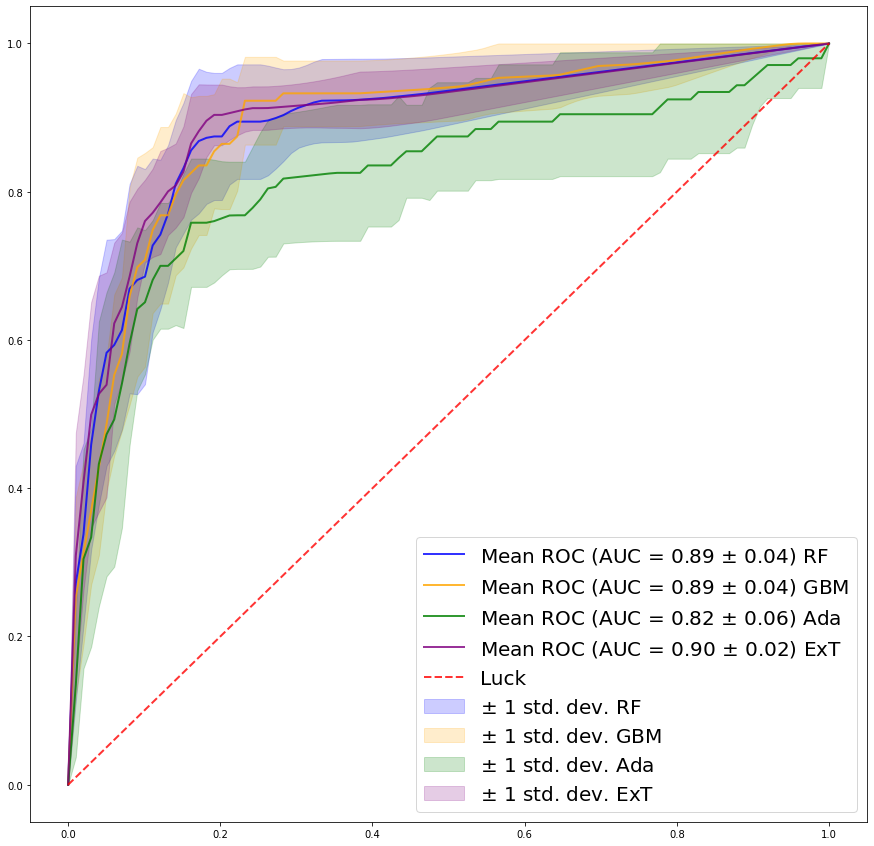

In [39]:
classifier1 = RandomForestClassifier(random_state=10)
classifier2 = GradientBoostingClassifier(random_state=10)
# classifier3=XGBClassifier(random_state=10)
classifier4 = AdaBoostClassifier(random_state=10)
classifier5 = ExtraTreesClassifier(random_state=10)

classifiers = [classifier1,classifier2,classifier4,classifier5]
model_names = ['RF','GBM','Ada','ExT']
colors = ['blue','orange','green','purple']

model_compare(classifiers, prep_features_train, y, model_names, colors)

-------